Loading intrinsic population
Loading GW population
Loading EM population (GRB prompt)

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero

Computing GRB PROMPT limiting thresholds
Saturation rates ETT GRB Afterglow: 340.9121558031563
Computing GRB PROMPT limiting thresholds
Computing GRB PROMPT limiting thresholds
Computing GRB PROMPT limiting thresholds


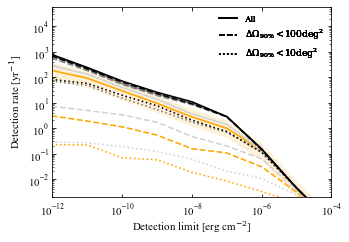

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec
from functions_ET import * 
import sys
sys.path.insert(0, '../code')
from Prompt_GRB.spectrum import photon_flux
sys.path.insert(0, '../COMPAS')
from spin_class import * 
import warnings
warnings.filterwarnings("ignore")


num = 1000000
eos = "SFHo"
mns_max = 2.058882

table = h5py.File('../horizons2/population/computed_population/bhns_%i_%s_z10_mass_spin_thv_GWFAST_ET.hdf5' %(num,eos),'r')

DCOtype='BHNS'
poptype='A'
path = '../horizons2/importance_sampling/mass_rate/ET_COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' # change this line! 

distribution = 'NOT fixed' #or 'NOT fixed'

spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

if poptype == 'A':
    w_type='w_000'
    r0 = 94
    w_type_high = 'w_000' #w_231
    r0_high = 203
    w_type_low = 'w_000' #w_312
    r0_low = 30
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_000' #w_231
    r0_high = 100
    w_type_low = 'w_312' #w_312
    r0_low = 10


### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()]
mns = table['mns'][()]
lamb_ns = table['lamb_ns'][()]
spin_bh = table['spin_bh'][()]
#i_tilt = table['i_tilt'][()]
z = table['z'][()]
dL = table['dL'][()]
thv = table['thv'][()]
ra = table['ra'][()]
dec = table['dec'][()]
#pol = table['pol'][()]
m_dyn = table['m_dyn'][()]
v_dyn = table['v_dyn'][()]
m_disk = table['m_disk'][()]
m_out = table['m_out'][()]
final_x = table['final_x'][()]
E_bkt = table['E_bkt'][()]
E_k_jet = table['E_k_jet'][()]
Ec = table['Ec'][()]

print("Loading GW population")

snr_ETT2CE = table['snr_ETT2CE'][()]
snr_ETT = table['snr_ETT'][()]
sky_loc_ETT2CE = table['sky_loc_ETT2CE'][()]
sky_loc_ETT = table['sky_loc_ETT'][()]

snr_ETL2CE = table['snr_ETL2CE'][()]
snr_ETL = table['snr_ETL'][()]
sky_loc_ETL2CE = table['sky_loc_ETL2CE'][()]
sky_loc_ETL = table['sky_loc_ETL'][()]

print("Loading EM population (GRB prompt)")
bol_fluence_prompt = table['bol_fluence_prompt'][()]
table.close()

### --- Weights --- ###

np.random.seed(0)
spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)


bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50

  
if distribution == 'NOT fixed':
    table_w = h5py.File('../horizons2/population/computed_population/weight/w_bhns_%s_%s_notfixed.hdf5' %(eos,spin_prescription),'r')
    #read
    C_mc = table_w['C_mc'][()]
    C_mc_low = table_w['C_mc_low'][()]
    C_mc_high = table_w['C_mc_high'][()]
    w = table_w['w'][()]
    w_low = table_w['w_low'][()]
    w_high = table_w['w_high'][()]  
    table_w.close()

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")


### --- Limiting Thresholds --- ###
lim_snr =12.

lim_prompt = np.logspace(-13,-4,10)
det_fermi = np.zeros(len(lim_prompt))
det_fermi_100 = np.zeros(len(lim_prompt))
det_fermi_10 = np.zeros(len(lim_prompt))
det_fermi = np.zeros(len(lim_prompt))
det_fermi_low = np.zeros(len(lim_prompt))
det_fermi_high = np.zeros(len(lim_prompt))
det_swift = np.zeros(len(lim_prompt))
detfermi = np.zeros(len(lim_prompt))
detswift = np.zeros(len(lim_prompt))
det_fermi_15 = np.zeros(len(lim_prompt))
det_swift_15 = np.zeros(len(lim_prompt))
detfermi_15 = np.zeros(len(lim_prompt))
detswift_15 = np.zeros(len(lim_prompt))

x = np.sort(z)
s = np.argsort(z)

#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=5., 3.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False

snr = [snr_ETT, snr_ETL, snr_ETT2CE, snr_ETL2CE]
sky = [sky_loc_ETT, sky_loc_ETL, sky_loc_ETT2CE, sky_loc_ETL2CE]
color_fermi = ['orange','lightgrey','grey','black']

for k in range(0,len(snr)):
    gw_snr = snr[k]
    sky_loc = sky[k]
    
    gw_det = gw_snr >= lim_snr
    
#GRB PROMPT
    print("Computing GRB PROMPT limiting thresholds")
    for i in range(len(lim_prompt)):
        prompt_det_fermi = bol_fluence_prompt[:,0] >= lim_prompt[i]
        #prompt_det_swift = flux_prompt[:,1,0] >= lim_prompt[i] 
        cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s])
        cum_gw_fermi_100 = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s]*(sky_loc[s]<100.))
        cum_gw_fermi_10 = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s]*(sky_loc[s]<10.))
        #cum_gw_swift = C_mc*np.cumsum(w[s]*prompt_det_swift[s]*gw_det[s])
        cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det[s])
        cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det[s])
        det_fermi[i] = cum_gw_fermi[-1]
        det_fermi_100[i] = cum_gw_fermi_100[-1]
        det_fermi_10[i] = cum_gw_fermi_10[-1]
        det_fermi_low[i] = cum_gw_fermi_low[-1]
        det_fermi_high [i] = cum_gw_fermi_high [-1]
        #det_swift[i] = cum_gw_swift[-1] 
        
    plt.plot(lim_prompt,det_fermi*0.6,ls='-',c=color_fermi[k],linewidth=1.6)
    plt.plot(lim_prompt,det_fermi_100*0.6,ls='--',c=color_fermi[k],linewidth=1.6)
    plt.plot(lim_prompt,det_fermi_10*0.6,ls=':',c=color_fermi[k],linewidth=1.6)
    
    leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=1,prop={'size': 9},frameon=False)
    plt.gca().add_artist(leg1)
    plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim((1.e-12,1.e-4))
    plt.ylim((2.e-3,6.e4))
    if k == 0:
        plt.fill_between(lim_prompt,det_fermi_high*0.6,det_fermi_low*0.6,color='orange',alpha=0.15,edgecolor="None")
        plt.ylabel(r'Detection rate [yr$^{-1}$]',size=11)
        print ("Saturation rates ETT GRB Afterglow:", det_fermi[0])
        leg1=plt.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls="--"),Line2D([0],[0],color='black',ls=":")],["All",r"$\Delta\Omega_{{\rm 90}\%}<100\mathrm{deg}^2$",r"$\Delta\Omega_{{\rm 90}\%}<10\mathrm{deg}^2$"],loc=1,prop={'size': 9},frameon=False)
        plt.gca().add_artist(leg1)
        #leg2=plt.legend([Line2D([0],[0],color='orange'),Line2D([0],[0],color='grey'),Line2D([0],[0],color='black')],[r"$ET \Delta$",r"$ET2L$",r"$ET \Delta+2CE$",],loc=3,prop={'size': 10},frameon=False)
        #plt.gca().add_artist(leg2)
        plt.tick_params(which='both',direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
        plt.xlabel(r'Detection limit [erg cm$^{-2}$]',size=11,labelpad=1) #np.savetxt("nsns_promptETT_colombo.txt",np.vstack([lim_prompt,det_fermi,det_fermi_high,det_fermi_low,det_fermi_100,det_fermi_10]).transpose())
        
    #if k == 1:
        #plt.yticks(color='w',size=1.)
        #print ("Saturation rates ETL GRB Afterglow:", det_fermi[0])
        #np.savetxt("nsns_promptETL_colombo.txt",np.vstack([lim_prompt,det_fermi,det_fermi_high,det_fermi_low,det_fermi_100,det_fermi_10]).transpose())


plt.show()